<a href="https://colab.research.google.com/github/koradee/CodeAlpha_StudentGradeTracker/blob/main/EV_Charging_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import joblib


In [2]:
df = pd.read_csv("ev_charging_patterns.csv")
df.shape

(1320, 20)

In [3]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

,Battery Capacity (kWh),Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years)
count,1320.000000,1254.000000,1320.000000,1254.000000,1320.000000,1320.000000,1320.000000,1254.000000,1320.000000,1320.000000
mean,74.534692,42.642894,2.269377,25.963003,22.551352,49.130012,75.141590,153.596788,15.263591,3.612843
std,20.626914,22.411705,1.061037,14.011326,10.751494,24.074134,17.080580,86.004987,14.831216,2.309824
min,1.532807,0.045772,0.095314,1.472549,0.234317,2.325959,7.604224,0.862361,-10.724770,0.000000
25%,62.000000,23.881193,1.397623,13.856583,13.368141,27.786903,62.053266,79.445335,2.800664,2.000000
50%,75.000000,42.691405,2.258136,25.603799,22.076360,48.241771,75.682496,152.259867,14.630846,4.000000
75%,85.000000,61.206218,3.112806,37.502998,31.646044,69.277921,88.201370,226.073284,27.981810,6.000000
max,193.003074,152.238758,7.635145,97.342255,69.407743,152.489761,177.708666,398.364775,73.169588,11.688592


In [4]:
df = df.dropna(subset=['Energy Consumed (kWh)'])
df.shape

(1254, 20)

In [5]:
numeric_cols = [
    'Charging Rate (kW)',
    'Distance Driven (since last charge) (km)'
]

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


In [6]:
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

# Extract hour (helps in peak demand)
df['Start Hour'] = df['Charging Start Time'].dt.hour


In [7]:
label_cols = [
    'Vehicle Model',
    'Charging Station Location',
    'Day of Week',
    'Charger Type',
    'User Type'
]

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])
df.fillna("Unknown", inplace=True)


In [8]:
X = df[
    [
        'Battery Capacity (kWh)',
        'Charging Duration (hours)',
        'Charging Rate (kW)',
        'Distance Driven (since last charge) (km)',
        'Temperature (°C)',
        'State of Charge (Start %)',
        'State of Charge (End %)',
        'Vehicle Age (years)',
        'Start Hour',
        'Charger Type'
    ]
]


In [9]:
y = df['Energy Consumed (kWh)']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [12]:
y_pred = model.predict(X_test)


In [13]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


MAE : 18.09976076873485
RMSE: 21.14640457996498
R2  : 0.012414299000312101


In [14]:
sample_input = np.array([[
    50,    # Battery Capacity (kWh)
    1.5,   # Charging Duration (hours)
    22,    # Charging Rate (kW)
    90,    # Distance Driven (km)
    32,    # Temperature
    30,    # SOC Start
    80,    # SOC End
    3,     # Vehicle Age
    18,    # Start Hour (6 PM)
    1,     # Charger Type (encoded)
]])

prediction = model.predict(sample_input)
print("Predicted Energy Demand (kWh):", prediction[0])


Predicted Energy Demand (kWh): 38.16470619781538


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


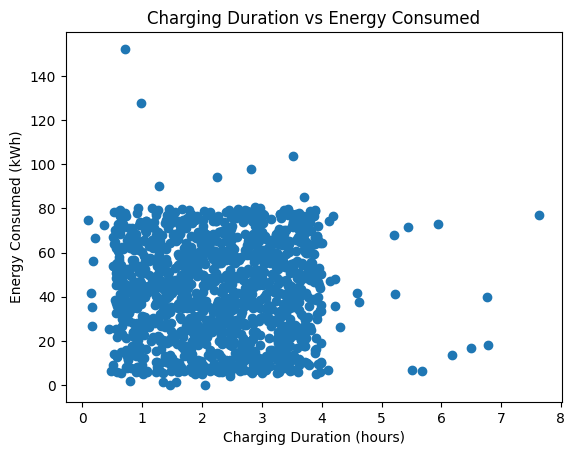

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df['Charging Duration (hours)'], df['Energy Consumed (kWh)'])
plt.xlabel("Charging Duration (hours)")
plt.ylabel("Energy Consumed (kWh)")
plt.title("Charging Duration vs Energy Consumed")
plt.show()


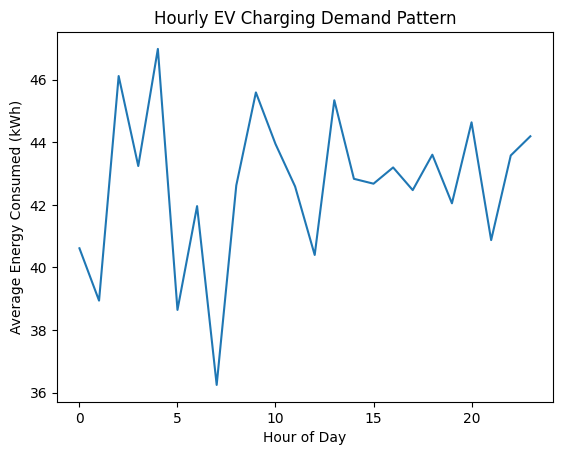

In [16]:
hourly_energy = df.groupby('Start Hour')['Energy Consumed (kWh)'].mean()

plt.figure()
plt.plot(hourly_energy.index, hourly_energy.values)
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy Consumed (kWh)")
plt.title("Hourly EV Charging Demand Pattern")
plt.show()


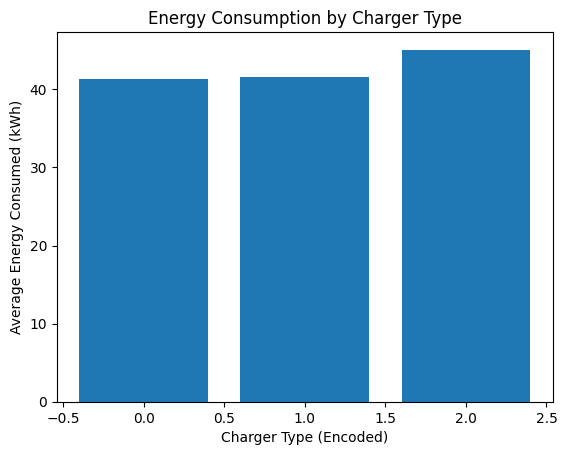

In [17]:
charger_energy = df.groupby('Charger Type')['Energy Consumed (kWh)'].mean()

plt.figure()
plt.bar(charger_energy.index, charger_energy.values)
plt.xlabel("Charger Type (Encoded)")
plt.ylabel("Average Energy Consumed (kWh)")
plt.title("Energy Consumption by Charger Type")
plt.show()


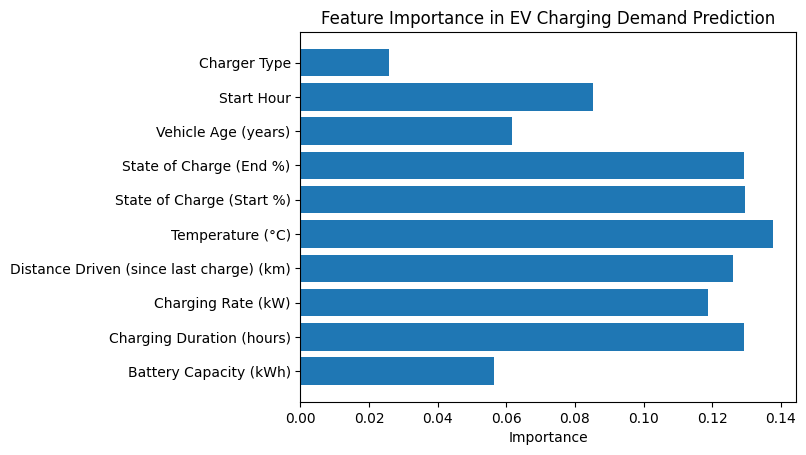

In [18]:
importances = model.feature_importances_
features = X.columns

plt.figure()
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance in EV Charging Demand Prediction")
plt.show()


In [19]:
joblib.dump(model, "ev_charging_demand_model.pkl")


['ev_charging_demand_model.pkl']

In [20]:
import gradio as gr
import numpy as np
import joblib

model = joblib.load("ev_charging_demand_model.pkl")

def predict_energy(
    battery_capacity,
    charging_duration,
    charging_rate,
    distance_driven,
    temperature,
    soc_start,
    soc_end,
    vehicle_age,
    start_hour,
    charger_type
):
    input_data = np.array([[
        battery_capacity,
        charging_duration,
        charging_rate,
        distance_driven,
        temperature,
        soc_start,
        soc_end,
        vehicle_age,
        start_hour,
        charger_type
    ]])

    prediction = model.predict(input_data)
    return f"**Predicted Energy Demand:** <span style='font-size:28px; color:#2E86C1;'><b>{prediction[0]:.2f} kWh</b></span>"


with gr.Blocks(title="EV Charging Demand Forecasting", theme=gr.themes.Default()) as demo:

    gr.Markdown("""
    <h1 style='text-align:center;'>EV Charging Demand Forecasting</h1>
    <p style='text-align:center; font-size:16px;'>
    Machine Learning based system to estimate <b>future EV charging energy demand</b>
    </p>
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Vehicle & Charging Details")

            battery_capacity = gr.Number(
                label="Battery Capacity (kWh)",
                value=50,
                precision=1
            )

            charging_duration = gr.Number(
                label="Charging Duration (hours)",
                value=1.5,
                precision=2
            )

            charging_rate = gr.Dropdown(
                choices=[7, 11, 22, 50],
                value=22,
                label="Charging Rate (kW)"
            )

            charger_type = gr.Radio(
                choices=[("AC", 0), ("DC", 1), ("Fast", 2)],
                value=2,
                label="Charger Type"
            )

        with gr.Column():
            gr.Markdown("###  Usage & Environment")

            distance_driven = gr.Number(
                label="Distance Driven since last charge (km)",
                value=90
            )

            temperature = gr.Number(
                label="Temperature (°C)",
                value=32
            )

            with gr.Row():
                soc_start = gr.Number(label="SOC Start (%)", value=30)
                soc_end = gr.Number(label="SOC End (%)", value=80)

            vehicle_age = gr.Dropdown(
                choices=[0, 1, 2, 3, 5, 8, 10,15],
                value=3,
                label="Vehicle Age (years)"
            )

            start_hour = gr.Slider(
                0, 23, step=1,
                value=18,
                label="Charging Start Hour (0–23)"
            )

    gr.Markdown("<br>")

    predict_btn = gr.Button(" Predict Energy Demand", variant="primary")

    output = gr.Markdown()

    predict_btn.click(
        predict_energy,
        inputs=[
            battery_capacity,
            charging_duration,
            charging_rate,
            distance_driven,
            temperature,
            soc_start,
            soc_end,
            vehicle_age,
            start_hour,
            charger_type
        ],
        outputs=output
    )

demo.launch()


/tmp/ipython-input-1745236339.py:36: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="EV Charging Demand Forecasting", theme=gr.themes.Default()) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b23b6ebd8627c5bee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
